### Mass balance calculation during mountain building


1. Obtain reliable grid data of Moho depth and elevation that covers the range of the Himalaya-Tibet orogen.
2. Calculate the volume of thickened crust for each grid based on equations (4) and (8) listed in the document.
3. Sum up the volumes for all the grids covering the region.



### Data

- [ETOPO5](https://data.europa.eu/data/datasets/dat-92-en/?locale=en)
- [CRUST1.0](https://igppweb.ucsd.edu/~gabi/crust1.html)
- [Natural Earth’s physical vectors (version 4.1.0)](https://www.naturalearthdata.com/downloads/50m-physical-vectors/50m-physical-labels/)

In [1]:
from osgeo import gdal
import os
import rasterio
from rasterio.mask import mask
import shapely
import geopandas
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
%matplotlib inline

In [2]:
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# parameters for cartopy
rivers    = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '50m',edgecolor='Blue', facecolor="none")
coastline = cfeature.NaturalEarthFeature('physical', 'coastline', '110m',edgecolor=(0.0,0.0,0.0),facecolor="none")
prj_base  = ccrs.PlateCarree()

# parameters for plot
xticks_global = np.arange(-180,180+10,60)
yticks_global = np.arange(-90,90+10,30)
xticks_area = np.arange(-180,180+2.5,2.5)
yticks_area = np.arange(-90,90+2.5,2.5)
xticks_area1 = np.arange(-180,180+5,5)
yticks_area1 = np.arange(-90,90+5,5)
dpi = 150

In [3]:
outputfile = "outpu_figs/"
outputPath = os.path.join(os.path.abspath("."),outputfile) 
if not os.path.exists(outputPath):
    os.makedirs(outputPath)

In [4]:
#Area_labels = ['Tibet','Alps','Pyrenees','Zagros']
#Area_names  = ['PLATEAU OF TIBET','ALPS','PYRENEES','ZAGROS MOUNTAINS']    


Area_names = ['CAUCASUS MTS.', 'HIMALAYAS', 'Dabie Mts.', 'Qinling Mountains', 'URAL MOUNTAINS', 'Taihang Mts.', 'ANDES', 'ROCKY MOUNTAINS', 'APPALACHIAN MTS.']

(-179.99999491497874, 180.00001581385732, -90.00000282004476, 90.00000254437327)


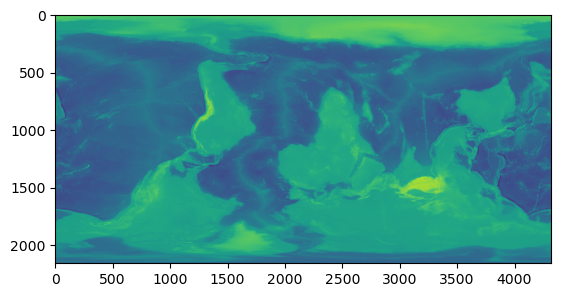

In [5]:
fname_DemETOPO5 = "../../../Data/DEM/ETOPO5.tif"
fname_DemETOPO1 = "../../../Data/DEM/ETOPO1_Bed_g_geotiff.tif"

# load ETOPO5
fname = fname_DemETOPO5 

gtiff = gdal.Open(fname)
gt = gtiff.GetGeoTransform()
img = np.flipud(gtiff.GetRasterBand(1).ReadAsArray())

minlon,maxlat = gt[0],gt[3]
dlon,dlat = gt[1], -gt[5]   #dlon,dlat = 5/60,5/60
nlon,nlat = img.shape[1],img.shape[0]
maxlon = minlon+dlon*nlon
minlat = maxlat-dlat*nlat
extent = (minlon,maxlon,minlat,maxlat)
print(extent)
plt.imshow(img)

#!gdalinfo $fname

In [6]:
# ### Data from litho1.0
# import litho1pt0 as litho

# extent = (-180,180,-90,90)
# nlon,nlat = (4320, 2160) #(21600, 10800) #(4320, 2160)
# minlon,maxlon,minlat,maxlat = extent
# lonv, latv = np.meshgrid(np.linspace(minlon,maxlon,nlon), np.linspace(minlat,maxlat,nlat), indexing='xy')


# l1 = litho.layer_depth(lat=latv, lon=lonv, layerID="WATER-BOTTOM")*0.001  # unit[km]
# l2 = litho.layer_depth(lat=latv, lon=lonv, layerID="CRUST1-TOP")*0.001
# l3 = litho.layer_depth(lat=latv, lon=lonv, layerID="CRUST1-BOTTOM")*0.001
# l4 = litho.layer_depth(lat=latv, lon=lonv, layerID="CRUST2-TOP")*0.001
# l5 = litho.layer_depth(lat=latv, lon=lonv, layerID="CRUST2-BOTTOM")*0.001
# l6 = litho.layer_depth(lat=latv, lon=lonv, layerID="CRUST3-TOP")*0.001
# l7 = litho.layer_depth(lat=latv, lon=lonv, layerID="CRUST3-BOTTOM")*0.001
# l8 = litho.layer_depth(lat=latv, lon=lonv, layerID="LID-TOP")*0.001
# l9 = litho.layer_depth(lat=latv, lon=lonv, layerID="LID-BOTTOM")*0.001

# topo = -l1 
# moho_depth = l6
# lab_depth = l9 

# cthickness = (l7 - l2) 
# mlthickness = (l9- l8) 
# lthickness = (l9 - l2) 

# fname_topo = outputPath+"litho1pt0_topo.tif"
# data = np.flipud(topo)
# array2geotiff(fname_topo,data,extent,gdal.GDT_Float32)

# fname_moho = outputPath+"litho1pt0_moho.tif"
# data = np.flipud(moho_depth)
# array2geotiff(fname_moho,data,extent,gdal.GDT_Float32)

In [7]:
from osgeo import gdal
from osgeo import osr

def array2geotiff(fname, data, extent, dtype):   
    """
    save GeoTiff file from the array of dem data
    input:
    fname: save file name
    data: elevation data, an array in size of (n_lat,n_lon) 
    latRange: range of latitude, an array as [minlat,maxlat]
    lonRange: range of longitude, an array as [minlon,maxlon]
    dtype: dtype in gdal, as gdal.GDT_Byte or gdal.GDT_Float32
    """   
    nx = data.shape[1]
    ny = data.shape[0]
    xmin,xmax,ymin,ymax = extent
    dx = (xmax - xmin) / float(nx)
    dy = (ymax - ymin) / float(ny)
    geotransform = (xmin, dx, 0, ymax, 0, -dy)
    dst = gdal.GetDriverByName('GTiff').Create(fname, nx, ny, 1, dtype)
    dst.SetGeoTransform(geotransform) 
    dst.GetRasterBand(1).WriteArray(data)
    srs = osr.SpatialReference()
    #srs.ImportFromEPSG(4326)
    srs.ImportFromEPSG(3857) # WGS84 lat/long
    #srs.ImportFromEPSG(9122) # WGS84 lat/long
    dst.SetProjection(srs.ExportToWkt())  
    dst.FlushCache() 

In [8]:
def loadxyz2grd(fname,order,dlon,dlat):
    """
    load .xyz file to grid
    input:
    fname: load file name
    order: the squence of lons and lats saving in .xyz 
    dlon:
    dlat: 
    
    data: elevation data, an array in size of (n_lat,n_lon) 
    latRange: range of latitude, an array as [minlat,maxlat]
    lonRange: range of longitude, an array as [minlon,maxlon]
    dtype: dtype in gdal, as gdal.GDT_Byte or gdal.GDT_Float32
    """ 
    data = np.loadtxt(fname)
    if order == "lonlat":
        lons,lats,z = data[:,0],data[:,1],data[:,2]
    if order == "latlon":
        lats,lons,z = data[:,0],data[:,1],data[:,2]
    minlon,maxlon,minlat,maxlat = lons.min(),lons.max(),lats.min(),lats.max()
    extent = (minlon,maxlon,minlat,maxlat)
    nlon = int((maxlon-minlon)/dlon+1)
    nlat = int((maxlat-minlat)/dlat+1)
    size = nlon*nlat
    data = np.zeros((nlat,nlon))
    for i in range(size):
        lon_idx = np.around((lons[i]-minlon)/dlon).astype("int")
        lat_idx = np.around((lats[i]-maxlat)/dlat).astype("int")
        data[lat_idx,lon_idx]=z[i]
    return data,extent

def interp2grid(extent0,dx0,dy0,data0,extent1,dx1,dy1,order): 
    """
    extent0,dx0,dy0,data0: source data
    extent1,dx1,dy1: target data
    """
    square0  = stripy.cartesian_meshes.square_mesh(extent0, dx0, dy0,refinement_levels=0)
    xmin0, xmax0, ymin0, ymax0 = extent0    
    data = np.zeros(square0.npoints)
    for i in range(square0.npoints):
        x = square0.x[i]
        y = square0.y[i]
        idx = np.around((x-xmin0)/dx0).astype(int)
        idy = np.around((y-ymin0)/dy0).astype(int)
        data[i] = data0[idy,idx]
    
    xmin1, xmax1, ymin1, ymax1 = extent1
    grid_x = np.arange(xmin1, xmax1+dx1/2, dx1)
    grid_y = np.arange(ymin1, ymax1+dy1/2, dy1)
    grid_xcoords, grid_ycoords = np.meshgrid(grid_x, grid_y)
    data1, ierr = square0.interpolate(grid_xcoords.ravel(), grid_ycoords.ravel(), data, order=order)
    nx = grid_x.shape[0]
    ny = grid_y.shape[0]
    data1 = data1.reshape(ny,nx)
    return data1

In [9]:
fname = "Data/crust1.0/depthtomoho.xyz"
dlon_crust1pt0_moho,dlat_crust1pt0_moho = 1,1
data_crust1pt0_moho,extent_crust1pt0_moho = loadxyz2grd(fname,"lonlat",dlon_crust1pt0_moho,dlat_crust1pt0_moho)
#data_ct_c1 = interp2grid(extent_ct0,dlon_ct0,dlat_ct0,data_ct0,extent_base,dlon_base,dlat_base,order=3)

In [10]:
fname_tif = outputPath+"crust1pt0_moho.tif"
data = np.flipud(data_crust1pt0_moho)
extent = extent_crust1pt0_moho
array2geotiff(fname_tif,data,extent,gdal.GDT_Float32)

In [11]:
# ### load test
# fname = fname_tif

# gtiff = gdal.Open(fname)
# gt = gtiff.GetGeoTransform()
# img = np.flipud(gtiff.GetRasterBand(1).ReadAsArray())

# minlon,maxlat = gt[0],gt[3]
# dlon,dlat = gt[1], -gt[5]   #dlon,dlat = 5/60,5/60
# nlon,nlat = img.shape[1],img.shape[0]
# maxlon = minlon+dlon*nlon
# minlat = maxlat-dlat*nlat
# extent = (minlon,maxlon,minlat,maxlat)
# print(extent)
# plt.imshow(img)

In [12]:
fname_shp = "Data/ne_50m_geography_regions_polys/ne_50m_geography_regions_polys.shp"

shp = geopandas.read_file(fname_shp)
shp_Unitm = shp.to_crs("EPSG:32662")

index_shp = []
for jj,name_jj in enumerate(Area_names):
    mtn_name = name_jj
    for ii, name_ii in enumerate(shp.name):
        if name_ii == mtn_name:
            print("The index of {}: {}".format(mtn_name,ii))
            index_shp.append(ii) 
index_shp = np.array(index_shp)

The index of CAUCASUS MTS.: 30
The index of HIMALAYAS: 31
The index of Dabie Mts.: 208
The index of Qinling Mountains: 426
The index of URAL MOUNTAINS: 29
The index of Taihang Mts.: 424
The index of ANDES: 32
The index of ROCKY MOUNTAINS: 33
The index of APPALACHIAN MTS.: 91


In [23]:
topo_mean = []
moho_mean = []
topo_median = []
moho_median = []

for ii,index in enumerate(index_shp):
    geom = shp.geometry[index]
    geom_map = [shapely.geometry.mapping(geom)]

    # topo
    fname_src = fname_DemETOPO5
    with rasterio.open(fname_src) as src:
        out_image, out_transform = mask(src, geom_map, crop=True)
        
    data = out_image[0,:,:]
    no_data = 0.
    row, col = np.where(data != no_data ) 
    data_real = np.extract(data != no_data, data)/1000.
    topo_mean.append(data_real.mean())
    topo_median.append(np.median(data_real))
    
    # moho
    fname_src = fname_tif
    with rasterio.open(fname_src) as src:
        out_image, out_transform = mask(src, geom_map, crop=True)
        
    data = out_image[0,:,:]
    no_data = 0.
    row, col = np.where(data != no_data ) 
    data_real = np.extract(data != no_data, data)
    data_mean = data_real.mean()
    moho_mean.append(data_real.mean())
    moho_median.append(np.median(data_real))

In [24]:
topo_mean = np.array(topo_mean)
moho_mean = np.array(moho_mean)

print(topo_mean)
print(moho_mean)

[1.34044794 3.79343713 0.22790464 1.02772612 0.45885353 1.04428075
 1.96614224 1.84331824 0.35258266]
[-42.856247 -49.33334  -32.536667 -37.490585 -46.22848  -35.51
 -44.272263 -39.507057 -40.420643]


In [25]:
print(topo_median)
print(moho_median)

[1.234, 4.419, 0.182, 1.066, 0.427, 1.219, 1.524, 1.83, 0.314]
[-43.7, -49.05, -32.015, -36.83, -45.75, -34.77, -42.79, -38.85, -40.2]


In [26]:
!pip install rasterio

     |████████████████████████████████| 21.3 MB 7.5 MB/s eta 0:00:01    |██▉                             | 1.9 MB 3.2 MB/s eta 0:00:07     |██████████▌                     | 7.0 MB 6.0 MB/s eta 0:00:03
  Using cached click_plugins-1.1.1-py2.py3-none-any.whl (7.5 kB)
  Using cached snuggs-1.4.7-py3-none-any.whl (5.4 kB)
  Using cached cligj-0.7.2-py3-none-any.whl (7.1 kB)
